# Dataset

In [68]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from step_3.datasets import COCOSegmentation

In [69]:
dataDir='../Datasets/coco-2017/'
dataType='val2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)

In [70]:
dataset = COCOSegmentation(dataDir, 'val', crop_size=0)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=None)

val set
loading annotations into memory...
Done (t=0.78s)
creating index...
index created!


In [4]:
i, l, n = dataset[0]
i.shape, l.shape, n

((427, 640, 3), torch.Size([427, 640]), '397133')

In [5]:
for (i, l, n) in dataloader:
    print(i.shape, l.shape, n)
    break

torch.Size([1, 427, 640, 3]) torch.Size([1, 427, 640]) ['397133']


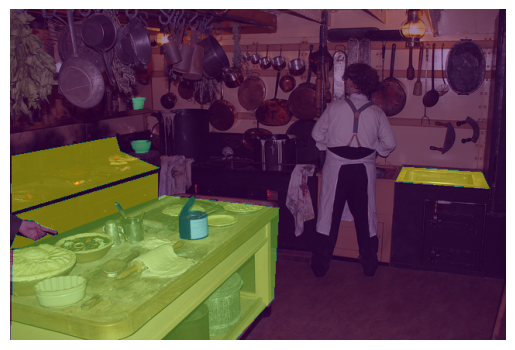

tensor([ 0,  1, 44, 49, 51, 67, 79, 81])

In [6]:
plt.imshow(i[0])
plt.imshow(l[0], alpha=0.5)
plt.axis('off')
plt.show()
l.unique()

# Model

In [8]:
import requests

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch

from step_3.fastsam import FastSAM, FastSAMPrompt
from step_3.utils import *

### Load model

In [9]:
torch.manual_seed(0)
np.random.seed(0)

GPU = -1

device = torch.device("cpu")

In [10]:
model = FastSAM('bin/FastSAM.pt')

### Get Input Image

In [11]:
img_url = "https://huggingface.co/ybelkada/segment-anything/resolve/main/assets/car.png"
raw_image = np.array(Image.open(requests.get(img_url, stream=True).raw).convert("RGB"))
print(raw_image.shape)
raw_image = torch.tensor(raw_image, dtype=torch.float32).permute((2,0,1))[None].to(device)
# plt.imshow(raw_image)
# plt.show()

(1764, 2646, 3)


In [12]:
raw_image.shape

torch.Size([1, 3, 1764, 2646])

In [13]:
raw_image = raw_image.detach().cpu().numpy()[0].transpose((1,2,0)).astype(np.uint8)

In [14]:
raw_image.shape

(1764, 2646, 3)

### Run Inference with Prompt

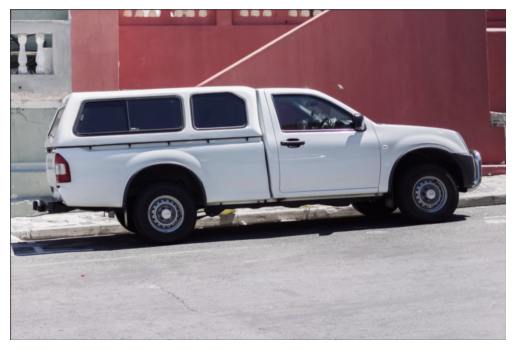

In [17]:
plt.imshow(raw_image)
plt.axis('off')
plt.show()

In [18]:
for i, l, n in dataloader:
    print(i.shape, l.shape)
    break

torch.Size([1, 427, 640, 3]) torch.Size([1, 427, 640])


In [19]:
i = i[0].detach().cpu().numpy().astype(np.uint8)

In [20]:
i.shape

(427, 640, 3)

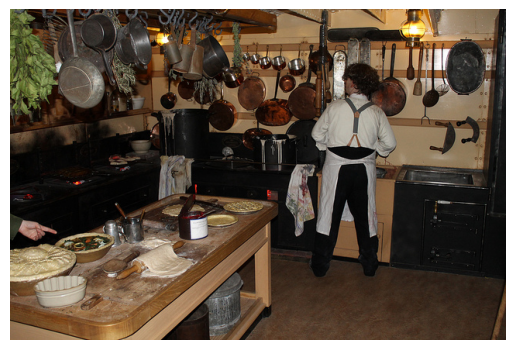

In [22]:
plt.imshow(i)
plt.axis('off')
plt.show()

In [63]:
input_points = [[180, 225]]
input_label = [1]

everything_results = model(i, device=device, retina_masks=True, imgsz=1024)#, conf=0., iou=0.)
prompt_process = FastSAMPrompt(i, everything_results, device=device)
mask, score = prompt_process.point_prompt(points=input_points, pointlabel=input_label)

0: 704x1024 166 objects, 551.0ms
Speed: 6.3ms preprocess, 551.0ms inference, 127.6ms postprocess per image at shape (1, 3, 1024, 1024)


In [64]:
m = torch.nn.functional.interpolate(mask[None,None].to(torch.uint8), [i.shape[0], i.shape[1]], mode='nearest')[0,0].bool()

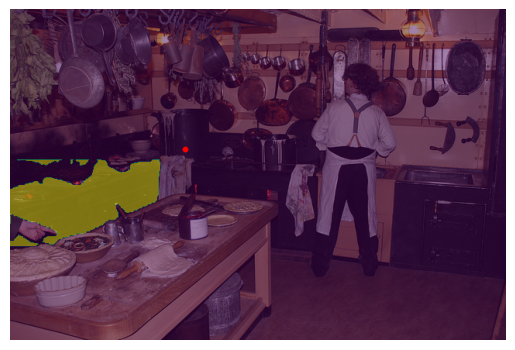

In [65]:
plt.imshow(i)
plt.imshow(m, alpha=0.5)
plt.scatter(input_points[0][1], input_points[0][0], c='r', s=10)
plt.axis('off')
plt.show()

In [66]:
print(score)

0.38124462962150574


# Outputs

In [ ]:
import random
import torch

In [ ]:
CENTER = False

In [ ]:
def get_output_masks(processor, model, i, input_points, device):

    with suppress_stdout():
        everything_results = model(i, device=device)
        prompt_process = FastSAMPrompt(i, everything_results, device=device)
        mask, score = prompt_process.point_prompt(points=input_points, pointlabel=[1])
    return mask, score
    
def get_prompt(name, label):

    # Load_prompts missing

    C = np.unique(label)[1:]
    c = np.random.choice(C)

    if CENTER:
        x, y = torch.sum(torch.argwhere(label==c),0)/torch.sum(label==c).detach().cpu().numpy()
        x, y = int(x), int(y)
    else:
        x_v, y_v = np.where(label == c)
        r = random.randint(0,len(x_v))
        x, y = x_v[r], y_v[r]
    return [[y,x]], c # inverted to compensate different indexing

In [ ]:
def get_masks():

    name_list, mask_list, score_list, prompt_list, p_class_list = [], [], [], [], []
    for j, (i, l, n) in enumerate(dataloader):

        prompt, p_class = get_prompt(n, l[0])
        # show_points_on_image(i[0], input_points[0])

        masks, scores = get_output_masks(None, model, i[0].detach().cpu().numpy().astype(np.uint8), prompt, device)
        # show_masks_on_image(i[0], masks, scores)  
        
        m = torch.nn.functional.upsample(masks[None,None].to(torch.uint8),[i.shape[1], i.shape[2]], mode='nearest')[0,0].bool().cpu().numpy()

        name_list.append(int(n[0]))
        mask_list.append(m)
        score_list.append(float(scores))
        prompt_list.append(prompt[0])
        p_class_list.append(int(p_class))

        if j > 3:
            break

    return name_list, prompt_list, p_class_list, mask_list, score_list

In [ ]:
name, prompt, p_class, mask, score = get_masks()

In [ ]:
i = 0
name[i], prompt[i], p_class[i], mask[i], score[i]

In [ ]:
plt.imshow(mask[i])
print(dataset.classes[p_class[i]])
print(name[i])
plt.scatter(*prompt[i])
plt.show()

In [ ]:
Image.open('../Datasets/coco-2017/val2017/' + str(name[i]).zfill(12) + '.jpg')

In [ ]:
for i, l, n in dataloader:
    plt.imshow(l[0])
    break

### Save DataFrame

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame({'name': name, 'prompt': prompt, 'class': p_class, 'mask': mask, 'score': score})

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
df.hist(column='class')

In [ ]:
df[['name', 'point', 'class']].to_pickle("results/coco_prompts.pkl")

In [ ]:
df[['name', 'point', 'class']]

In [ ]:
df = pd.read_pickle("results/cityscapes_prompts.pkl")

In [ ]:
df.head()

In [ ]:
df[df['name']==632][['point', 'class']].values[0][1]

### Predicted Classes

In [ ]:
N_CLASSES = 92

In [ ]:
def get_instance(label, c=None):
    if c is None:
        C = np.unique(label)[1:]
        c = np.random.choice(C)
        return label == c, c
    else:
        return label == c, c

def get_pred_classes(inst, label, n_classes, threshold=0.01):
    im = torch.logical_not(inst).to(torch.uint8)
    im[im==1] = n_classes
    m = im + label
    h, _ = np.histogram(m, bins=256, range=(0,255))
    clean_h = h[:n_classes]
    mask_tot = np.sum(clean_h)
    classes = np.where(clean_h > threshold * mask_tot)[0]
    return list(classes)

### Test class threshold

In [ ]:
# Label
l = torch.zeros((224,224), dtype=torch.uint8)
l[100:150, 50:100] = 35
l[145:150, 95:100] = 91
l[100:140, 160:200] = 60
l[100:115, 50:65] = 0

plt.imshow(l)
plt.show()

In [ ]:
# Predicted instance
i = torch.zeros((224,224), dtype=bool)
i[100:150, 50:100] = True
plt.imshow(i)
plt.show()

In [ ]:
get_pred_classes(i, l, N_CLASSES, 0.01)

In [ ]:
# Modified instance
im = torch.logical_not(i).to(torch.uint8)
im[im==1] = N_CLASSES

plt.imshow(im)
plt.show()

In [ ]:
im.min(), im.max()

In [ ]:
# Mask (intersection)
m = im + l

plt.imshow(m)
plt.show()

In [ ]:
m.unique()

In [ ]:
h, _ = np.histogram(m, bins=256, range=(0,255))
h

In [ ]:
clean_h = h[:N_CLASSES]
clean_h

In [ ]:
mask_tot = np.sum(clean_h)
mask_tot

In [ ]:
np.where(clean_h > 0.01 * mask_tot)

# Metrics

In [76]:
from pathlib import Path
import numpy as np
import pandas as pd
import PIL.Image as Image
import matplotlib.pyplot as plt

from step_2.utils import show_points_and_masks_on_image

%matplotlib inline
%load_ext autoreload

In [87]:
DATASET = 'coco'
EXPERIMENT = 'center'
MODEL = 'FastSAM'
ROOT = Path("../Datasets/coco-2017/val2017/") if DATASET == 'coco' else Path("../Datasets/Cityscapes/leftImg8bit/val/")
SPARSITY = 0
CLASSES = ['background', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant',
           'street sign', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 
           'hat', 'backpack', 'umbrella', 'shoe', 'eye glasses', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports', 'kite', 
           'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'plate', 'wine glass', 'cup', 'fork', 'knife', 
           'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
           'potted plant', 'bed', 'mirror', 'dining table', 'window', 'desk', 'toilet', 'door', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
           'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'blender', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
           'hair drier', 'toothbrush', 'hair brush']

In [88]:
def calculate_metrics(target, pred, eps=1e-5, verbose=False):

    if verbose:
        plt.subplot(1, 2, 1)
        plt.imshow(target)
        plt.subplot(1, 2, 2)
        plt.imshow(pred)
        plt.show()

    output = np.reshape(pred, -1)
    target = np.reshape(target, -1)

    tp = np.sum(output * target)  # TP (Intersection)
    un = np.sum(output + target)  # Union
    fp = np.sum(output * (~target))  # FP
    fn = np.sum((~output) * target)  # FN
    tn = np.sum((~output) * (~target))  # TN

    iou = (tp + eps) / (un + eps)
    pixel_acc = (tp + tn + eps) / (tp + tn + fp + fn + eps)
    dice = (2 * tp + eps) / (2 * tp + fp + fn + eps)
    precision = (tp + eps) / (tp + fp + eps)
    recall = (tp + eps) / (tp + fn + eps)
    specificity = (tn + eps) / (tn + fp + eps)

    if verbose:
        print(f"IoU: {iou:.4f}, Pixel Acc: {pixel_acc:.4f}, Dice: {dice:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, Specificity: {specificity:.4f}")

    return iou, pixel_acc, dice, precision, specificity, recall

def get_analytics(target_df, pred_df):
    metrics = {k: [] for k in ['name', 'prompt', 'class', 't_class', 's_class', 'score', 'score_diff', 'mask_size', 
                               'mask_size_diff', 'iou', 'pixel_acc', 'dice', 'precision', 'recall', 'specificity']}
    for i in range(len(target_df)):
        target = target_df.loc[i]
        pred = pred_df.loc[i]

        iou, pixel_acc, dice, precision, specificity, recall = calculate_metrics(target['mask'], pred['mask'])
        
        metrics['name'].append(target['name'])
        metrics['prompt'].append(target['prompt'])
        metrics['class'].append(target['class'])
        metrics['t_class'].append(target['s_class'])
        metrics['s_class'].append(pred['s_class'])
        metrics['score'].append(pred['score'])
        metrics['score_diff'].append((pred['score'] - target['score']) / (target['score'] + 1e-5))
        p_size = np.mean(pred['mask'].astype('float'))
        t_size = np.mean(target['mask'].astype('float'))
        metrics['mask_size'].append(p_size)
        metrics['mask_size_diff'].append((p_size - t_size) / (t_size + 1e-3))
        metrics['iou'].append(iou)
        metrics['pixel_acc'].append(pixel_acc)
        metrics['dice'].append(dice)
        metrics['precision'].append(precision)
        metrics['recall'].append(recall)
        metrics['specificity'].append(specificity)
    
    return pd.DataFrame(metrics)

def get_labels(name):
    if isinstance(name, list):
        return [get_labels(n) for n in name]
    else: 
        return CLASSES[name].title()

def get_image(name):
    if DATASET == 'coco':
        image_path = ROOT.joinpath(f'{str(name).zfill(12)}.jpg')
    else:
        image_path = ROOT.joinpath(f"{name.split('_')[0]}/{name}")
    return np.array(Image.open(image_path).convert("RGB"))

def show_entry(row, target_df, pred_df):
    image = get_image(row['name'])
    target_mask = target_df[target_df['name']==row['name']]['mask'].values[0]
    pred_mask = pred_df[pred_df['name']==row['name']]['mask'].values[0]
    show_points_and_masks_on_image(image, [pred_mask, target_mask], [row['prompt']])
    print(f'ID: {row["name"]}, PromptClass: {get_labels(row["class"])}, TargetClass: {get_labels(row["t_class"])}, PredClass: {get_labels(row["s_class"])},') 
    print(f'ScoreDiff: {row["score_diff"]:.4f}, MaskSizeDiff: {row["mask_size_diff"]:.4f}, IoU: {row["iou"]:.4f}')
    
def show_samples(pie_df, target_df, pred_df, n=5):
    print('Legend: Target -> Orange, Prediction -> Blue')
    pie_df.iloc[:n].apply(lambda x: show_entry(x, target_df, pred_df), axis=1)

In [89]:
df_p = pd.read_pickle(f"results/{EXPERIMENT}{DATASET}_prompts.pkl")
df_0 = pd.read_pickle(f"results/{EXPERIMENT}{DATASET}_MobileSAM_0.pkl")
df_s = pd.read_pickle(f"results/{EXPERIMENT}{DATASET}_{MODEL}_{SPARSITY}.pkl")
df_0.head()

,name,prompt,class,s_class,mask,score
0,397133,"[178, 343]",67,[67],"[[False, False, False, False, False, False, Fa...",0.953392
1,37777,"[326, 152]",82,"[0, 82]","[[False, False, False, False, False, False, Fa...",0.992129
2,252219,"[358, 283]",1,[1],"[[False, False, False, False, False, False, Fa...",0.983938
3,87038,"[268, 301]",2,[2],"[[False, False, False, False, False, False, Fa...",0.968638
4,174482,"[96, 48]",10,"[0, 10]","[[False, False, False, False, False, False, Fa...",0.917567


In [90]:
df_0s = get_analytics(df_0, df_s)
df_0s.head()

,name,prompt,class,t_class,s_class,score,score_diff,mask_size,mask_size_diff,iou,pixel_acc,dice,precision,recall,specificity
0,397133,"[178, 343]",67,[67],[67],0.864997,-0.092716,0.007695,0.059288,9.068352e-01,0.999272,9.511417e-01,0.921065,9.832487e-01,0.999388
1,37777,"[326, 152]",82,"[0, 82]",[],0.000000,-0.999990,0.000000,-0.989407,1.322401e-09,0.906596,1.322401e-09,1.000000,1.322401e-09,1.000000
2,252219,"[358, 283]",1,[1],[1],0.964379,-0.019879,0.013774,-0.545439,4.314404e-01,0.982017,6.028060e-01,0.990724,4.331904e-01,0.999868
3,87038,"[268, 301]",2,[2],[],0.000000,-0.999990,0.000000,-0.608762,2.092050e-08,0.998444,2.092050e-08,1.000000,2.092050e-08,1.000000
4,174482,"[96, 48]",10,"[0, 10]","[0, 10]",0.364103,-0.603180,0.001563,0.024142,9.120603e-01,0.999859,9.540079e-01,0.935567,9.731903e-01,0.999899


In [91]:
min_size = df_0s.nsmallest(25, ['mask_size_diff'])
max_size = df_0s.nlargest(25, ['mask_size_diff'])
min_score = df_0s.nsmallest(25, ['score_diff']) # not very useful
max_score = df_0s.nlargest(25, ['score_diff']) # not very useful
min_iou = df_0s.nsmallest(25, ['iou'])
max_iou = df_0s.nlargest(25, ['iou'])
min_size.head()

,name,prompt,class,t_class,s_class,score,score_diff,mask_size,mask_size_diff,iou,pixel_acc,dice,precision,recall,specificity
2582,496409,"[314, 173]",35,[0],[],0.0,-0.99999,0.0,-0.998983,5.428734e-11,0.017573,5.428734e-11,1.0,5.428734e-11,1.0
585,135673,"[328, 209]",5,[0],[],0.0,-0.99999,0.0,-0.998982,3.730661e-11,0.019142,3.730661e-11,1.0,3.730661e-11,1.0
3614,214703,"[260, 401]",42,[0],[],0.0,-0.99999,0.0,-0.998972,3.765145e-11,0.028125,3.765145e-11,1.0,3.765145e-11,1.0
2362,196442,"[188, 247]",35,[0],[],0.0,-0.99999,0.0,-0.998963,3.798108e-11,0.036560,3.798108e-11,1.0,3.798108e-11,1.0
659,433980,"[189, 265]",1,"[0, 1]",[],0.0,-0.99999,0.0,-0.998958,5.561086e-11,0.040955,5.561086e-11,1.0,5.561086e-11,1.0


In [92]:
max_iou.head()

,name,prompt,class,t_class,s_class,score,score_diff,mask_size,mask_size_diff,iou,pixel_acc,dice,precision,recall,specificity
1641,366199,"[324, 330]",65,"[0, 65]","[0, 65]",0.927581,-0.074528,0.402748,0.000925,0.995411,0.998148,0.997700,0.997238,0.998163,0.998139
1658,283412,"[61, 360]",47,[47],[47],0.977543,-0.033470,0.062090,-0.003065,0.994660,0.999667,0.997323,0.998880,0.995770,0.999926
116,48153,"[249, 248]",1,[1],[1],0.944304,-0.063320,0.212928,0.002048,0.994549,0.998837,0.997267,0.996243,0.998293,0.998984
976,40757,"[102, 65]",72,"[0, 72]","[0, 72]",0.953248,-0.049089,0.098022,0.005488,0.992842,0.999298,0.996408,0.993661,0.999170,0.999312
2280,305317,"[179, 328]",38,[0],[0],0.969189,-0.041013,0.727988,0.006482,0.992519,0.994551,0.996245,0.993033,0.999478,0.981671


Legend: Target -> Orange, Prediction -> Blue


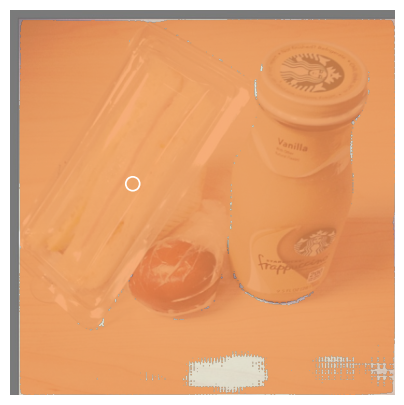

ID: 173091, PromptClass: Sandwich, TargetClass: ['Bottle', 'Sandwich', 'Dining Table'], PredClass: [],
ScoreDiff: -1.0000, MaskSizeDiff: -0.9989, IoU: 0.0000


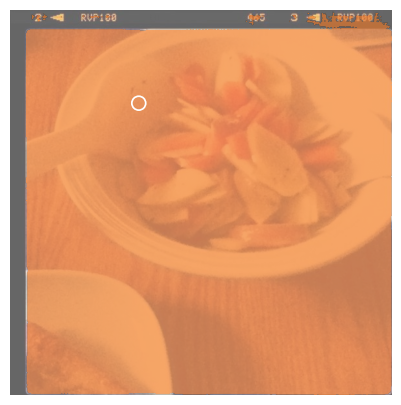

ID: 116362, PromptClass: Spoon, TargetClass: ['Background', 'Spoon', 'Bowl', 'Dining Table'], PredClass: [],
ScoreDiff: -1.0000, MaskSizeDiff: -0.9988, IoU: 0.0000


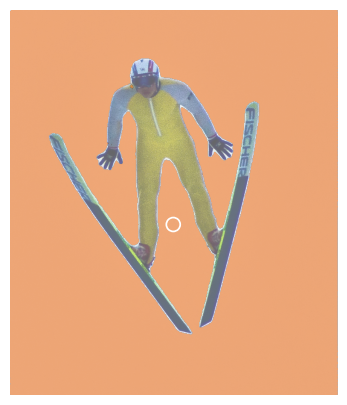

ID: 352760, PromptClass: Skis, TargetClass: ['Background'], PredClass: [],
ScoreDiff: -1.0000, MaskSizeDiff: -0.9988, IoU: 0.0000


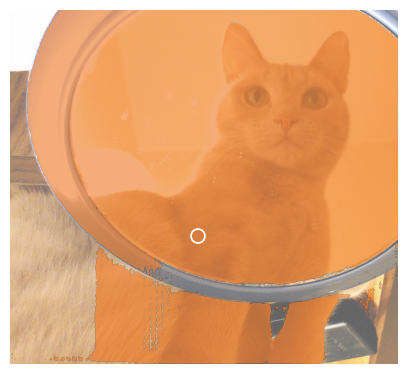

ID: 63552, PromptClass: Cat, TargetClass: ['Background', 'Cat'], PredClass: [],
ScoreDiff: -1.0000, MaskSizeDiff: -0.9987, IoU: 0.0000


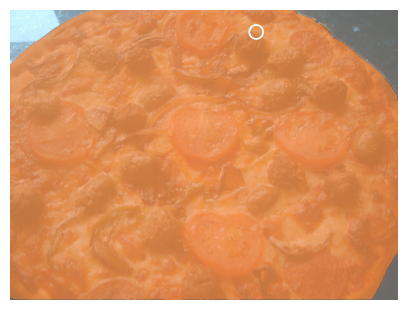

ID: 340015, PromptClass: Dining Table, TargetClass: ['Pizza'], PredClass: [],
ScoreDiff: -1.0000, MaskSizeDiff: -0.9989, IoU: 0.0000


In [97]:
show_samples(min_iou, df_0, df_s, 5)

array([[<Axes: title={'center': 'score'}>]], dtype=object)

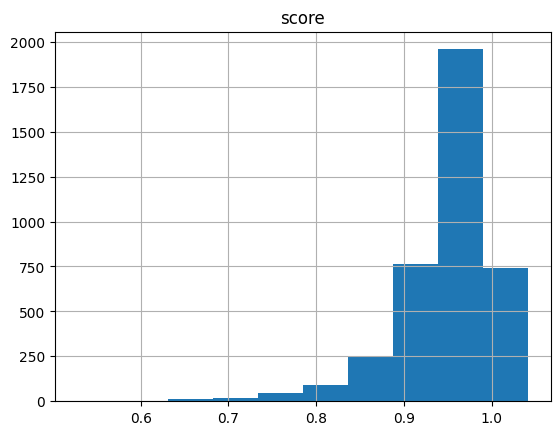

In [99]:
df_0.hist(column='score')

# Test

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch

In [ ]:
m = torch.zeros((224,224), dtype=bool)
o = torch.ones((50,50), dtype=bool)
m[100:150, :50] = o

In [ ]:
plt.imshow(m)
x, y = torch.argwhere(m==1).sum(0)/torch.sum(m)
x, y = int(x), int(y)
print(x, y)
plt.scatter(y, x, color='red')
plt.show()

### Edge Tolerance for prompts

In [67]:
import cv2

In [71]:
i, l, n = dataset[0]

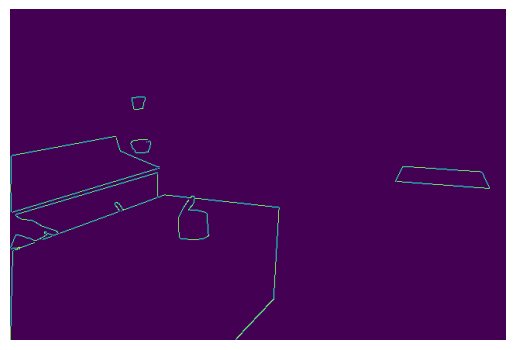

In [116]:
e = cv2.Canny(image=l.numpy().astype(np.uint8), threshold1=10, threshold2=50)
plt.imshow(e)
plt.axis('off')
plt.show()

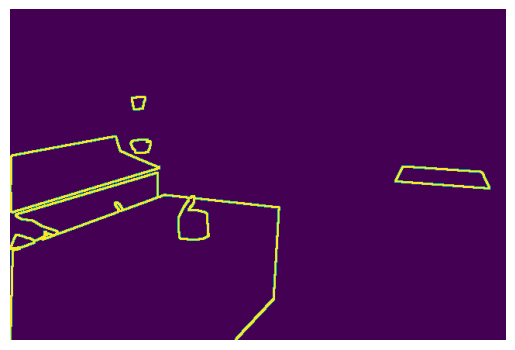

In [117]:
e = cv2.dilate(e, np.ones((3, 3), np.uint8), iterations = 1)
plt.imshow(e)
plt.axis('off')
plt.show()

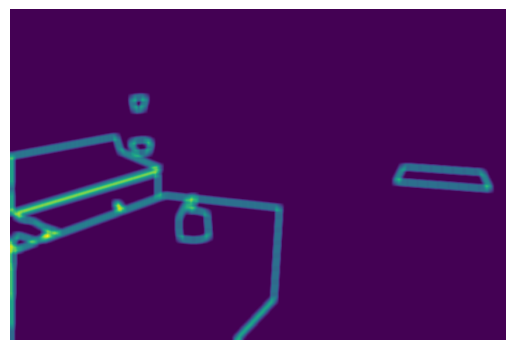

In [118]:
e = cv2.blur(e, (10,10))
plt.imshow(e)
plt.axis('off')
plt.show()